In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
# ==================== 读取数据 ==================== #

df = pd.read_csv('FS_NYC.csv')                          #自动把第一行做列属性
df = df.loc[:,['userId','venueCategory']]               #取出用户ID和地点ID

# ==================== 获得地址字典 ==================== #

location = []                                           #取出所有的地址
for i in range(df.shape[0]):
    location.append(df.iloc[i,1])
location = list(set(location))                          #去重
loc_dict = dict(zip(location,range(len(location)))) #给这251个地点创建字典

# ==================== 分组获得每个人的运动轨迹 ==================== #

loc_rep = df.replace(loc_dict)                          #将地址名称替换成字典里的数字

def sliding_window(seq, window_size):
    result = []
    for i in range(len(seq)-window_size):
        result.append(seq[i:i+window_size])
    return result

train_set, test_set = [], []
window_size = 10   #窗口大小为10
for userId, group in loc_rep.groupby('userId'):
    full_seq = group['venueCategory']
    full_len = full_seq.shape[0]
    train_seq = full_seq.iloc[:int(full_len*0.8)].to_list()
    test_seq = full_seq.iloc[int(full_len*0.8):].to_list()
    train_set += sliding_window(train_seq, window_size)
    test_set += sliding_window(test_seq, window_size)

In [3]:
# ==================== LSTM模型 ==================== #

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=hidden_size)
        self.gates = nn.Linear(hidden_size+hidden_size, hidden_size*4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.out = nn.Linear(hidden_size, output_size)
        
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
        

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        x = self.embedding(x)
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, \
            output_gate, candidate_cell = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g) for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.out(h))
        return (h,c) , torch.stack(y_list, dim=1)

def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]
    
def train_evaluate(model, data_set, batch_size, optimizer):
    model.train()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for batch in next_batch(shuffle(data_set), batch_size):
        batch = torch.from_numpy(np.array(batch)).long().to(device) #embedding层的输入需要long形式
        x = batch[:, :window_size-1].long().to(device)
        label =  batch[: , -1].long().to(device)
        hidden, out = model(x)                                 #输入直接是(batch_size, seq)，不用扩展最后一维
        prediction = out[:, -1, :].squeeze(-1)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_l_sum += loss.item()
        train_acc_sum += (prediction.argmax(dim=1) == label).sum().item() / label.shape[0]
        n += 1  #每个batch+1
    return train_l_sum/n, train_acc_sum/n

def test_evaluate(model, data_set, batch_size):
    model.eval()
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch in next_batch(shuffle(data_set), batch_size):
            batch = torch.from_numpy(np.array(batch)).long().to(device) #embedding层的输入需要long形式
            x = batch[:, :window_size-1].long().to(device)
            label =  batch[: , -1].long().to(device)
            hidden, out = model(x)                                 #输入直接是(batch_size, seq)，不用扩展最后一维
            prediction = out[:, -1, :].squeeze(-1)
            loss = loss_func(prediction, label)
            train_l_sum += loss.item()
            train_acc_sum += (prediction.argmax(dim=1) == label).sum().item() / label.shape[0]
            n += 1  #每个batch+1
    return train_l_sum/n, train_acc_sum/n

In [5]:
# ==================== LSTM模型 ==================== #

device = 'cuda:1'
num_class = len(loc_dict)
model = MyLSTM(input_size=num_class, hidden_size=1024, output_size=num_class).to(device) #输出size是地址类别

loss_func = nn.CrossEntropyLoss()                                    #多分类问题使用CrossEntropyLoss函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,30], gamma=0.1)

loss_train = []
loss_test = []
acc_train = []
acc_test = []
batch_size = 4096
num_epoch = 50
total_time_start = datetime.datetime.now()
for epoch in range(num_epoch):
    start = datetime.datetime.now()
    train_l, train_acc = train_evaluate(model, train_set, batch_size, optimizer)
    test_l, test_acc = test_evaluate(model, test_set, batch_size)
    #scheduler.step()
    loss_train.append(train_l)
    acc_train.append(train_acc)
    loss_test.append(test_l)
    acc_test.append(test_acc)
    end = datetime.datetime.now()
    print('epoch %d, loss_train %f, loss_test %f, acc_train %f, acc_test %f, time %s'% 
          (epoch+1, loss_train[epoch], loss_test[epoch], acc_train[epoch], acc_test[epoch], end - start))
total_time_end = datetime.datetime.now()
print("LSTM模型的运行时间：",total_time_end - total_time_start)

epoch 1, loss_train 4.253493, loss_test 3.959815, acc_train 0.159213, acc_test 0.189320, time 0:00:11.669897
epoch 2, loss_train 3.803268, loss_test 3.772024, acc_train 0.207290, acc_test 0.208215, time 0:00:11.814718
epoch 3, loss_train 3.661575, loss_test 3.693068, acc_train 0.218311, acc_test 0.212997, time 0:00:11.863064
epoch 4, loss_train 3.581557, loss_test 3.645432, acc_train 0.224528, acc_test 0.214585, time 0:00:11.994397
epoch 5, loss_train 3.526001, loss_test 3.619459, acc_train 0.228252, acc_test 0.218181, time 0:00:11.946009
epoch 6, loss_train 3.481150, loss_test 3.608130, acc_train 0.232391, acc_test 0.219001, time 0:00:11.882342
epoch 7, loss_train 3.436067, loss_test 3.604111, acc_train 0.236663, acc_test 0.219455, time 0:00:12.044436
epoch 8, loss_train 3.393313, loss_test 3.595571, acc_train 0.241555, acc_test 0.221089, time 0:00:12.164256
epoch 9, loss_train 3.345217, loss_test 3.602452, acc_train 0.246726, acc_test 0.220947, time 0:00:12.081420
epoch 10, loss_trai

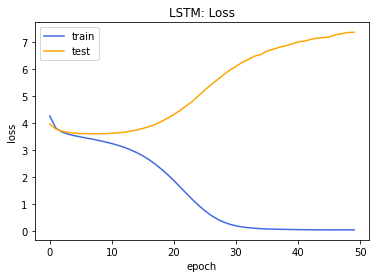

In [6]:
plt.plot(loss_train ,label='train',color='royalblue')
plt.plot(loss_test ,label='test', color='orange')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("LSTM: Loss")
plt.legend()
plt.show()

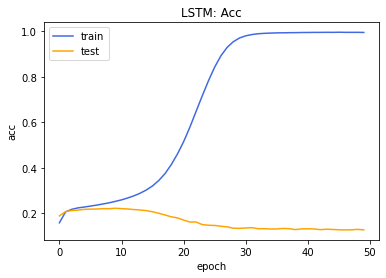

In [7]:
plt.plot(acc_train ,label='train',color='royalblue')
plt.plot(acc_test ,label='test', color='orange')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("LSTM: Acc")
plt.legend()
plt.show()

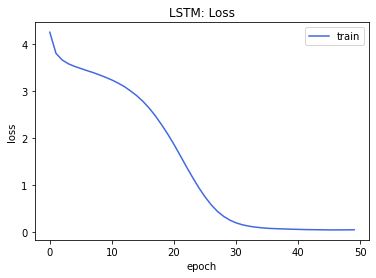

In [8]:
plt.plot(loss_train ,label='train',color='royalblue')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("LSTM: Loss")
plt.legend()
plt.show()

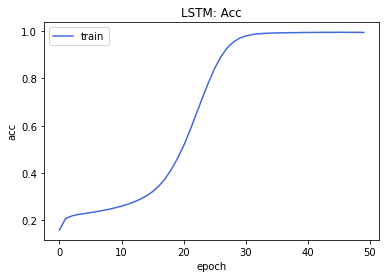

In [9]:
plt.plot(acc_train ,label='train',color='royalblue')
plt.ylabel("acc")
plt.xlabel("epoch")
plt.title("LSTM: Acc")
plt.legend()
plt.show()